Import Libraries

In [14]:
import pandas as pd
from bs4 import BeautifulSoup
import sqlite3
import numpy as np

In [15]:

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)
# Set display options
pd.set_option('display.max_rows', None) # Show all rows 
pd.set_option('display.width', None) # Auto-adjust width to display all columns
pd.set_option('display.max_colwidth', None) # Show full content of each column without truncation


Extract

In [16]:
 
# XML Setup
# Read the XML file
with open('population_data.xml', 'r') as f:
  xml_data = f.read()

# Parse the XML data
soup = BeautifulSoup(xml_data, 'lxml')

# Initialize empty lists to store data
data = {'country_or_area': [], 'item': [], 'year': [], 'value': []}

# Find all record elements
records = soup.find_all('record')

# Extract data from each record
for record in records:
  country_or_area = record.find('field', {'name': 'Country or Area'})
  item = record.find('field', {'name': 'Item'})
  year = record.find('field', {'name': 'Year'})
  value = record.find('field', {'name': 'Value'})
   
  
  if country_or_area and item and year and value:
    data['country_or_area'].append(country_or_area.text)
    data['item'].append(item.text)
    data['year'].append(year.text)
    data['value'].append(value.text)

In [17]:
#connection to the database 
conn = sqlite3.connect('population_data.db')


In [18]:
# Data Loading
projects_df = pd.read_csv("projects_data.csv", dtype='str')
population_df = pd.read_csv("population_data.csv", skiprows=4)
population_json_df = pd.read_json('population_data.json',orient='records')
population_xml_df = pd.DataFrame(data) 
population_sql_df = pd.read_sql('SELECT * FROM population_data', conn)
rural_df = pd.read_csv('rural_population_percent.csv',skiprows=4)
electricity_df = pd.read_csv('electricity_access_percent.csv',skiprows=4)
gdp_df = pd.read_csv('gdp_data.csv', skiprows=4) 
# Read the CSV file using UTF-16 encoding
mistery_df = pd.read_csv('mystery.csv', encoding='utf-16')


In [76]:

import requests

# Extract unique country codes from population_df
country_codes = population_df['country_code'].unique()

# Initialize an empty list to store DataFrames
dfs = []

# Loop through each country code
for country_code in country_codes:
    # Construct the API URL for the current country code
    api_url = f"https://api.worldbank.org/v2/countries/{country_code}/indicators/SP.POP.TOTL/?format=json"
    
    # Make the API request
    response = requests.get(api_url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Load JSON response into DataFrame
        json_data = response.json()
        data = json_data[1]  # The actual data is in the second element of the JSON response
        df = pd.DataFrame(data)
        # Append the DataFrame to the list
        dfs.append(df)
    else:
        print(f"Failed to fetch data for country code: {country_code}")

# Concatenate all DataFrames into a single DataFrame
final_df = pd.concat(dfs, ignore_index=True)

country_name    2668
country_code    2668
year            2668
value           2668
dtype: int64

In [70]:
api_url

'https://api.worldbank.org/v2/countries/ARB;CEB;CSS;EAP;EAR;EAS;ECA;ECS;EMU;EUU;FCS;HIC;HPC;IBD;IBT;IDA;IDB;IDX;LAC;LCN;LDC;LIC;LMC;LMY;LTE;MEA;MIC;MNA;NAC;OED;OSS;PRE;PSS;PST;SAS;SSA;SSF;SST;TEA;TEC;TLA;TMN;TSA;TSS;UMC;WLD/indicators/SP.POP.TOTL/?format=json'

In [68]:
country_codes

array(['ARB', 'CEB', 'CSS', 'EAP', 'EAR', 'EAS', 'ECA', 'ECS', 'EMU',
       'EUU', 'FCS', 'HIC', 'HPC', 'IBD', 'IBT', 'IDA', 'IDB', 'IDX',
       'LAC', 'LCN', 'LDC', 'LIC', 'LMC', 'LMY', 'LTE', 'MEA', 'MIC',
       'MNA', 'NAC', 'OED', 'OSS', 'PRE', 'PSS', 'PST', 'SAS', 'SSA',
       'SSF', 'SST', 'TEA', 'TEC', 'TLA', 'TMN', 'TSA', 'TSS', 'UMC',
       'WLD'], dtype=object)

In [63]:
df.head()

,indicator,country,countryiso3code,date,value,unit,obs_status,decimal
0,"{'id': 'SP.POP.TOTL', 'value': 'Population, total'}","{'id': '1A', 'value': 'Arab World'}",ARB,2023,NaN,,,0
1,"{'id': 'SP.POP.TOTL', 'value': 'Population, total'}","{'id': '1A', 'value': 'Arab World'}",ARB,2022,464684914.0,,,0
2,"{'id': 'SP.POP.TOTL', 'value': 'Population, total'}","{'id': '1A', 'value': 'Arab World'}",ARB,2021,456520777.0,,,0
3,"{'id': 'SP.POP.TOTL', 'value': 'Population, total'}","{'id': '1A', 'value': 'Arab World'}",ARB,2020,449228296.0,,,0
4,"{'id': 'SP.POP.TOTL', 'value': 'Population, total'}","{'id': '1A', 'value': 'Arab World'}",ARB,2019,441467739.0,,,0


In [64]:
# Extracting indicator information
df['indicator_id'] = df['indicator'].apply(lambda x: x['id'])
df['indicator_name'] = df['indicator'].apply(lambda x: x['value'])

# Extracting country information
df['country_code'] = df['countryiso3code']
df['year'] = df['date']
df['country_name'] = df['country'].apply(lambda x: x['value'])

# Dropping the original columns
df.drop(['indicator', 'country'], axis=1, inplace=True)

# Reordering columns
df = df[['country_name', 'country_code', 'indicator_id', 'indicator_name', 'year', 'value']]


In [67]:
df['country_name'].unique()

array(['Arab World'], dtype=object)

Transform

**Combination of rural_population_percent.csv dan electricity_access_percent.csv**

In [20]:
main_df = pd.concat([rural_df, electricity_df])

Data Cleaning

In [21]:
rural_df.drop(['Unnamed: 62'],axis=1,inplace=True)
electricity_df.drop(['Unnamed: 62'],axis=1,inplace=True)
projects_df.drop(['Unnamed: 56'], axis=1, inplace=True)
population_sql_df.drop(['index'],axis=1,inplace=True)
population_df.drop(['Unnamed: 62'],axis=1,inplace=True)
mistery_df.drop(['Unnamed: 0'],axis=1,inplace=True) 
gdp_df.drop(['Unnamed: 62'], axis=1,inplace=True)
main_df.drop(['Unnamed: 62'],axis=1,inplace=True)



In [22]:
# Trim whitespace from the beginning and end of column names, then rename columns
projects_df.columns = [col.strip().lower().replace(' ', '_') for col in projects_df.columns]
population_df.columns = [col.strip().lower().replace(' ', '_') for col in population_df.columns]
population_json_df.columns = [col.strip().lower().replace(' ', '_') for col in population_json_df.columns]
population_xml_df.columns = [col.strip().lower().replace(' ', '_') for col in population_xml_df.columns]
population_sql_df.columns = [col.strip().lower().replace(' ', '_') for col in population_sql_df.columns]
main_df.columns = [col.strip().lower().replace(' ', '_') for col in main_df.columns]
mistery_df.columns = [col.strip().lower().replace(' ', '_') for col in mistery_df.columns]
gdp_df.columns = [col.strip().lower().replace(' ', '_') for col in gdp_df.columns]
rural_df.columns = [col.strip().lower().replace(' ', '_') for col in rural_df.columns]
electricity_df.columns = [col.strip().lower().replace(' ', '_') for col in electricity_df.columns]


In [23]:

# filter out values that are not countries
non_countries = ['World',
 'High income',
 'OECD members',
 'Post-demographic dividend',
 'IDA & IBRD total',
 'Low & middle income',
 'Middle income',
 'IBRD only',
 'East Asia & Pacific',
 'Europe & Central Asia',
 'North America',
 'Upper middle income',
 'Late-demographic dividend',
 'European Union',
 'East Asia & Pacific (excluding high income)',
 'East Asia & Pacific (IDA & IBRD countries)',
 'Euro area',
 'Early-demographic dividend',
 'Lower middle income',
 'Latin America & Caribbean',
 'Latin America & the Caribbean (IDA & IBRD countries)',
 'Latin America & Caribbean (excluding high income)',
 'Europe & Central Asia (IDA & IBRD countries)',
 'Middle East & North Africa',
 'Europe & Central Asia (excluding high income)',
 'South Asia (IDA & IBRD)',
 'South Asia',
 'Arab World',
 'IDA total',
 'Sub-Saharan Africa',
 'Sub-Saharan Africa (IDA & IBRD countries)',
 'Sub-Saharan Africa (excluding high income)',
 'Middle East & North Africa (excluding high income)',
 'Middle East & North Africa (IDA & IBRD countries)',
 'Central Europe and the Baltics',
 'Pre-demographic dividend',
 'IDA only',
 'Least developed countries: UN classification',
 'IDA blend',
 'Fragile and conflict affected situations',
 'Heavily indebted poor countries (HIPC)',
 'Low income',
 'Small states',
 'Other small states',
 'Not classified',
 'Caribbean small states',
 'Pacific island small states']

# remove non countries from the data
population_df = population_df[population_df['country_name'].isin(non_countries)]
population_json_df = population_json_df[population_json_df['country_name'].isin(non_countries)]
population_sql_df = population_sql_df[population_sql_df['country_name'].isin(non_countries)] 
population_xml_df = population_xml_df[population_xml_df['country_or_area'].isin(non_countries)] 

Datatypes Adjustment on every dataframe

In [24]:
def convert_to_datetime(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col])

def remove_commas_and_convert_to_float(df, columns):
    for col in columns:
        df[col] = df[col].str.replace(',', '').astype(float)

def clean_string_columns(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: x.split('!$!')[0] if isinstance(x, str) else x)

def fill_na_with_value(df, columns, value):
    for col in columns:
        df[col].fillna(value, inplace=True)

def replace_nan_with_zero(df, columns):
    for col in columns:
        if col in df.columns:
            df[col].fillna(0, inplace=True)

# Convert columns to datetime
convert_to_datetime(projects_df, ['boardapprovaldate', 'closingdate'])

# Remove commas and convert to float
remove_commas_and_convert_to_float(projects_df, ['lendprojectcost', 'ibrdcommamt', 'idacommamt', 'totalamt', 'grantamt'])

# Apply lambda function to countryname column
projects_df['countryname'] = projects_df['countryname'].apply(lambda x: x.split(';')[0].strip() if (';' in x) and (x.split(';')[0].strip() == x.split(';')[1].strip()) else x)

# Clean sector and theme columns
clean_string_columns(projects_df, ['sector1', 'sector2', 'sector3', 'sector4', 'sector5', 'theme1', 'theme2', 'theme3', 'theme4', 'theme5'])

# Concatenate values of sector and theme columns
projects_df['sector'] = projects_df[['sector1', 'sector2', 'sector3', 'sector4', 'sector5']].apply(lambda row: ';'.join(row.dropna()), axis=1)
projects_df['theme'] = projects_df[['theme1', 'theme2', 'theme3', 'theme4', 'theme5']].apply(lambda row: ';'.join(row.dropna()), axis=1)

# Clean location column
projects_df['country'] = projects_df['location'].apply(lambda x: ';'.join([loc.split('!$!')[-1] for loc in x.split(';')]) if isinstance(x, str) else np.NaN)

# Apply regex replacement to string columns
projects_df.replace({'^(\(Historic\))': ''}, regex=True, inplace=True)

# Drop columns with all NaN values
projects_df.dropna(axis=1, how='all', inplace=True)

# Replace NaN values with 0 in numeric columns
replace_nan_with_zero(projects_df, projects_df.select_dtypes(include=['number']).columns)
# Replace NaN values with 0 in numeric columns
replace_nan_with_zero(mistery_df, mistery_df.select_dtypes(include=['number']).columns)



C:\Users\Dans\AppData\Local\Temp\ipykernel_9700\2426380334.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  projects_df.replace({'^(\(Historic\))': ''}, regex=True, inplace=True)
C:\Users\Dans\AppData\Local\Temp\ipykernel_9700\2426380334.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[co

Data Imputing

In [25]:
# Fill missing values in GDP and population DataFrames using backward fill followed by forward fill
columns_to_fill = gdp_df.columns[4:62]  # Assuming columns "1960" to "2017"
columns_to_fill_2 = electricity_df.columns[4:62]  # Assuming columns "1960" to "2017"
gdp_df[columns_to_fill] = gdp_df[columns_to_fill].fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)
population_df[columns_to_fill] = population_df[columns_to_fill].fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)
population_json_df[columns_to_fill] = population_json_df[columns_to_fill].fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)
population_sql_df[columns_to_fill] = population_sql_df[columns_to_fill].fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)
rural_df[columns_to_fill] = rural_df[columns_to_fill].fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)
electricity_df[columns_to_fill_2] = electricity_df[columns_to_fill_2].fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)

# Mean Imputation for 'boardapprovaldate' and 'closingdate' columns in projects_df
boardapprovaldate_mean = projects_df['boardapprovaldate'].mean()
closingdate_mean = projects_df['closingdate'].mean()
projects_df['boardapprovaldate'].fillna(boardapprovaldate_mean, inplace=True)
projects_df['closingdate'].fillna(closingdate_mean, inplace=True)


# Mode Imputation for other categorical columns in projects_df
columns_to_fill = ['supplementprojectflg', 'countryname', 'prodline', 'lendinginstr', 'productlinetype', 'projectstatusdisplay', 'status']
for column in columns_to_fill:
    most_frequent_value = projects_df[column].mode()[0]
    projects_df[column].fillna(most_frequent_value, inplace=True)


C:\Users\Dans\AppData\Local\Temp\ipykernel_9700\49747192.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_df[columns_to_fill] = gdp_df[columns_to_fill].fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)
C:\Users\Dans\AppData\Local\Temp\ipykernel_9700\49747192.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  population_df[columns_to_fill] = population_df[columns_to_fill].fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)
C:\Users\Dans\AppData\Local\Temp\ipykernel_9700\49747192.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  population_json_df[columns_to_fill] = population_json_df[columns_to_fill].fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)
C:\Users\Dans\AppData\L

In [26]:
population_df = population_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
population_json_df = population_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
population_sql_df = population_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
gdp_df = gdp_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
rural_df = rural_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
electricity_df = electricity_df.dropna(subset=['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])


In [27]:
population_df = population_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
population_json_df = population_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
population_sql_df = population_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
gdp_df = gdp_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
rural_df = rural_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
electricity_df = electricity_df.dropna(subset=['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])


population_xml_df['year'] = population_xml_df['year'].astype('int')
population_xml_df['value'] = population_xml_df['value'].replace('', np.nan)
population_xml_df['value'] = population_xml_df.sort_values('year').groupby('country_or_area')['value'].fillna(method='ffill').fillna(method='bfill').astype(float)

C:\Users\Dans\AppData\Local\Temp\ipykernel_9700\1414368288.py:3: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  population_xml_df['value'] = population_xml_df.sort_values('year').groupby('country_or_area')['value'].fillna(method='ffill').fillna(method='bfill').astype(float)
C:\Users\Dans\AppData\Local\Temp\ipykernel_9700\1414368288.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  population_xml_df['value'] = population_xml_df.sort_values('year').groupby('country_or_area')['value'].fillna(method='ffill').fillna(method='bfill').astype(float)
C:\Users\Dans\AppData\Local\Temp\ipykernel_9700\1414368288.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a fut

In [28]:
population_df = population_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
population_json_df = population_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
population_sql_df = population_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
gdp_df = gdp_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
rural_df = rural_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
electricity_df = electricity_df.dropna(subset=['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])


population_xml_df['year'] = population_xml_df['year'].astype('int')
population_xml_df['value'] = population_xml_df['value'].replace('', np.nan)
population_xml_df['value'] = population_xml_df.sort_values('year').groupby('country_or_area')['value'].fillna(method='ffill').fillna(method='bfill').astype(float)

population_df = population_df.drop(columns=['indicator_name', 'indicator_code'])
population_json_df = population_json_df.drop(columns=['indicator_name', 'indicator_code'])
population_sql_df = population_sql_df.drop(columns=['indicator_name', 'indicator_code'])
population_xml_df = population_xml_df.drop(columns=['item'])
gdp_df = gdp_df.drop(columns=['indicator_name', 'indicator_code'])
rural_df = rural_df.drop(columns=['indicator_name', 'indicator_code'])
electricity_df = electricity_df.drop(columns=['indicator_name', 'indicator_code'])

In [29]:
population_df = population_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
population_json_df = population_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
population_sql_df = population_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
gdp_df = gdp_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
rural_df = rural_df.dropna(subset=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
electricity_df = electricity_df.dropna(subset=['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])


population_xml_df['year'] = population_xml_df['year'].astype('int')
population_xml_df['value'] = population_xml_df['value'].replace('', np.nan)
population_xml_df['value'] = population_xml_df.sort_values('year').groupby('country_or_area')['value'].fillna(method='ffill').fillna(method='bfill').astype(float)

population_df = population_df.drop(columns=['indicator_name', 'indicator_code'])
population_json_df = population_json_df.drop(columns=['indicator_name', 'indicator_code'])
population_sql_df = population_sql_df.drop(columns=['indicator_name', 'indicator_code'])
population_xml_df = population_xml_df.drop(columns=['item'])
gdp_df = gdp_df.drop(columns=['indicator_name', 'indicator_code'])
rural_df = rural_df.drop(columns=['indicator_name', 'indicator_code'])
electricity_df = electricity_df.drop(columns=['indicator_name', 'indicator_code'])

# Melt the DataFrame to stack the '1960' to '2017' columns into a single 'year' column
population_df = population_df.melt(id_vars=['country_name', 'country_code'], var_name='year', value_name='value')# Melt the DataFrame to stack the '1960' to '2017' columns into a single 'year' column
population_json_df = population_json_df.melt(id_vars=['country_name', 'country_code'], var_name='year', value_name='value')# Melt the DataFrame to stack the '1960' to '2017' columns into a single 'year' column
population_sql_df = population_sql_df.melt(id_vars=['country_name', 'country_code'], var_name='year', value_name='value')
gdp_df = gdp_df.melt(id_vars=['country_name', 'country_code'], var_name='year', value_name='gdp')
rural_df = rural_df.melt(id_vars=['country_name', 'country_code'], var_name='year', value_name='ruralpopulationpercent')
electricity_df = electricity_df.melt(id_vars=['country_name', 'country_code'], var_name='year', value_name='electricityaccesspercent')

gdp_df['year'] = gdp_df['year'].astype('int')
population_df['year'] = population_df['year'].astype('int')
population_json_df['year'] = population_json_df['year'].astype('int')
population_sql_df['year'] = population_sql_df['year'].astype('int')
population_xml_df['year'] = population_xml_df['year'].astype('int')
rural_df['year'] = rural_df['year'].astype('int')
electricity_df['year'] = electricity_df['year'].astype('int')
 
# Reset the index
population_df = population_df.reset_index(drop=True)
population_json_df = population_json_df.reset_index(drop=True)
population_sql_df = population_sql_df.reset_index(drop=True)
gdp_df = gdp_df.reset_index(drop=True)
rural_df = rural_df.reset_index(drop=True)
electricity_df = electricity_df.reset_index(drop=True)

projects_df = projects_df.drop_duplicates()
population_df = population_df.drop_duplicates()
population_json_df = population_json_df.drop_duplicates()
population_sql_df = population_sql_df.drop_duplicates()
population_xml_df = population_xml_df.drop_duplicates()
gdp_df = gdp_df.drop_duplicates()

In [30]:
population_df.nunique()

country_name      46
country_code      46
year              58
value           2522
dtype: int64

Drop Duplicates

In [31]:
projects_df = projects_df.drop_duplicates()
population_df = population_df.drop_duplicates()
population_json_df = population_json_df.drop_duplicates()
population_sql_df = population_sql_df.drop_duplicates()
population_xml_df = population_xml_df.drop_duplicates()
gdp_df = gdp_df.drop_duplicates()

Outlier Handling

In [32]:

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
def analyze_data(df, skew_threshold=0.6, variation_threshold=0.1, verbose=True):
    """
    Analyze the data and identify skewed, low variation, and non-skewed columns.

    Parameters:
    df (DataFrame): Data to be analyzed.
    skew_threshold (float): Threshold for skewness to identify skewed columns.
    variation_threshold (float): Threshold for standard deviation to identify low variation columns.
    verbose (bool): Whether to print analysis details.

    Returns:
    Tuple: Tuple containing lists of skewed, low variation, and non-skewed columns.
    """

    SKEWED_COLUMNS = []
    NOT_SKEWED_COLUMNS = []
    LOW_VARIATION_COLUMNS = []

    for column in df.columns:
        if df[column].dtype in ['float64', 'int64']:
            skewness = df[column].skew()
            std_dev = df[column].std()
            if verbose:
                print(f"Column: {column}")
                print(f"Skewness: {skewness}")
                print(f"Standard Deviation: {std_dev}")

            if abs(skewness) >= skew_threshold:
                SKEWED_COLUMNS.append(column)
                if verbose:
                    print("Column is skewed.")
            elif abs(std_dev) < variation_threshold and abs(std_dev) != 0.0:
                LOW_VARIATION_COLUMNS.append(column)
                if verbose:
                    print("Column has low variation.")
            else:
                NOT_SKEWED_COLUMNS.append(column)
                if verbose:
                    print("Column is not skewed.")

    return SKEWED_COLUMNS, LOW_VARIATION_COLUMNS, NOT_SKEWED_COLUMNS


In [34]:
from feature_engine.outliers import Winsorizer

projects_df_capped = projects_df.copy()
population_sql_df_capped = population_sql_df.copy()
population_df_capped = population_df.copy()
population_json_df_capped = population_json_df.copy()
population_xml_df_capped = population_xml_df.copy()
gdp_df_capped = gdp_df.copy()

In [35]:


# Apply Winsorizer to numeric columns
for column in ['lendprojectcost', 'ibrdcommamt', 'idacommamt', 'totalamt']:
    winsoriser_iqr = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=[column])
    projects_df_capped[column] = winsoriser_iqr.fit_transform(projects_df[[column]])


# Apply Winsorizer to numeric columns
for column in ['grantamt']:
    winsoriser_iqr = Winsorizer(capping_method='gaussian', tail='both', fold=2, variables=[column])
    projects_df_capped[column] = winsoriser_iqr.fit_transform(projects_df[[column]])



In [36]:


numeric_columns = population_df.select_dtypes(include=['float64', 'int64']).columns

# Apply Winsorizer to numeric columns
for column in numeric_columns:
    winsoriser_iqr = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=[column])
    population_df_capped[column] = winsoriser_iqr.fit_transform(population_df_capped[[column]])
    population_json_df_capped[column] = winsoriser_iqr.fit_transform(population_json_df_capped[[column]])
    population_sql_df_capped[column] = winsoriser_iqr.fit_transform(population_sql_df_capped[[column]]) 
    population_xml_df_capped[column] = winsoriser_iqr.fit_transform(population_xml_df_capped[[column]]) 

winsoriser_iqr = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['gdp'])
gdp_df_capped['gdp'] = winsoriser_iqr.fit_transform(gdp_df_capped[['gdp']]) 

In [37]:
# Cek Outliers on df
def plot_boxplot(df_before, df_after): 
    for column in df_before.columns:
        if df_before[column].dtype in ['float64', 'int64']:
            plt.figure(figsize=(16, 4))

            # Boxplot
            plt.subplot(1, 2, 1)
            sns.boxplot(y=df_before[column])
            plt.title(f"Before Outlier Handling, Vertical Boxplot of {column}")

                # Boxplot
            plt.subplot(1, 2, 2)
            sns.boxplot(y=df_after[column])
            plt.title(f"After Outlier Handling, Vertical Boxplot of {column}")

            plt.show() 
             

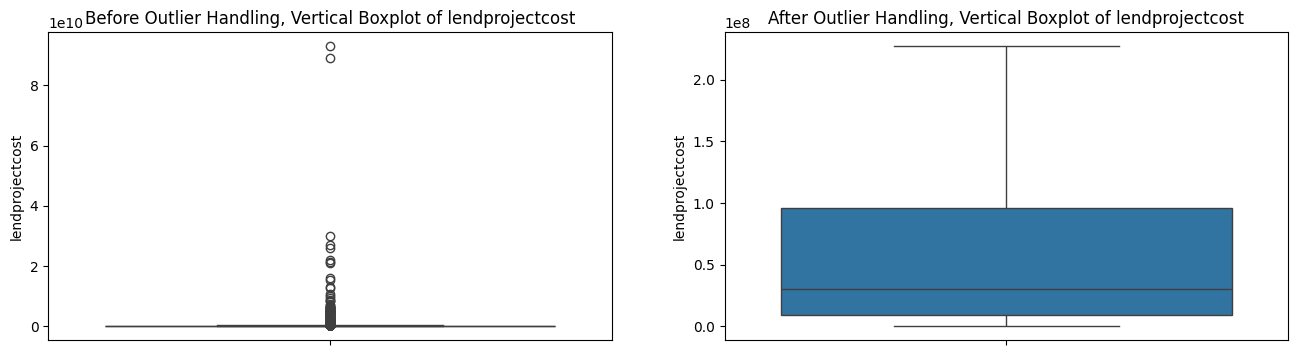

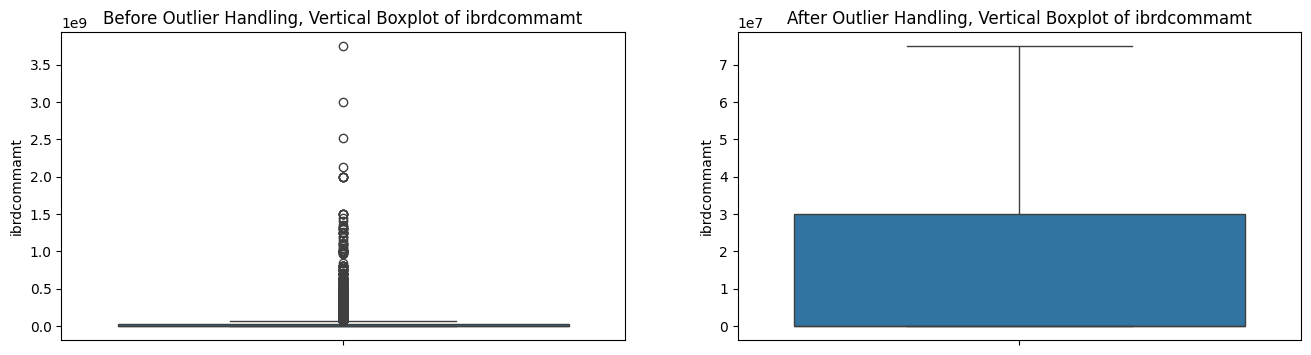

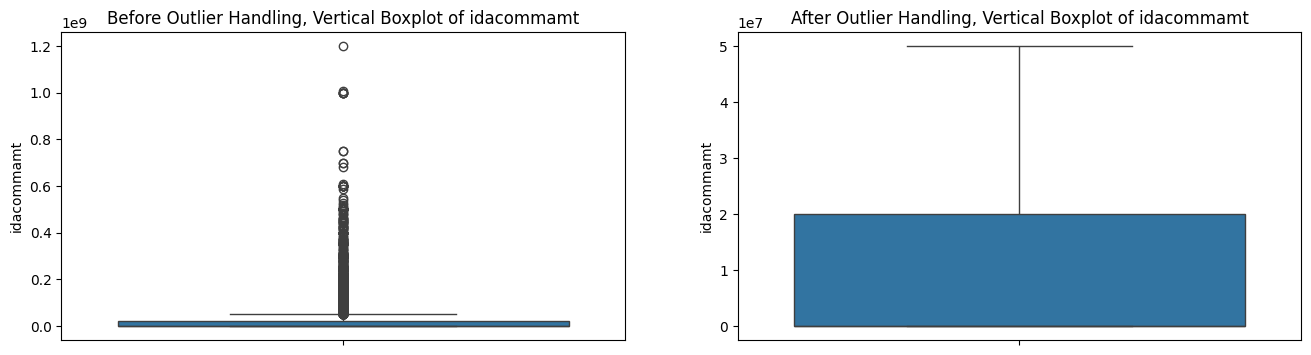

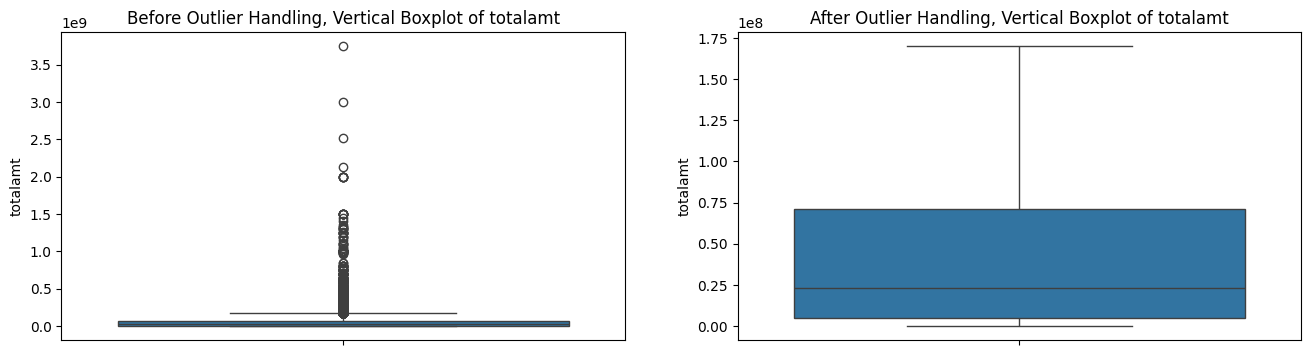

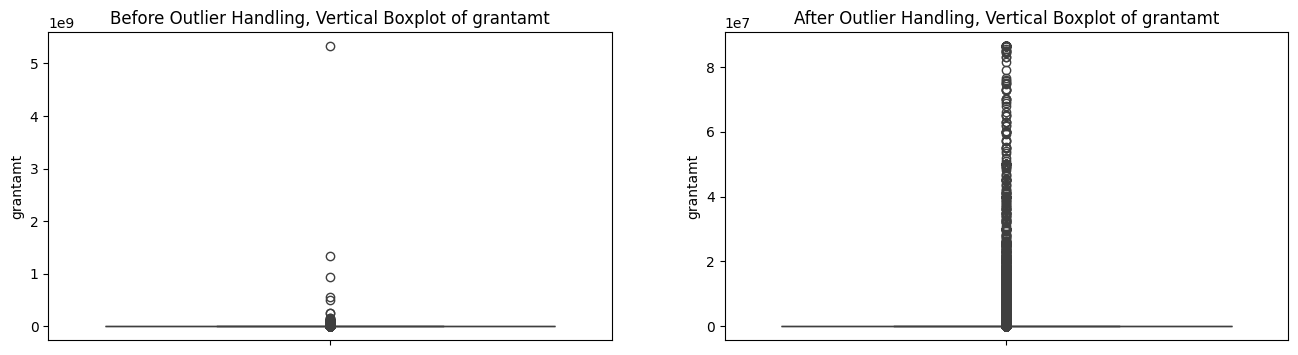

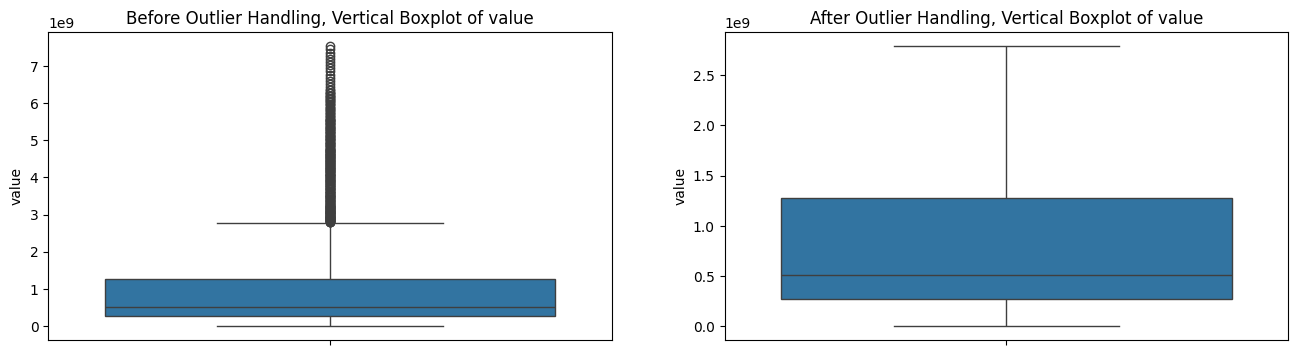

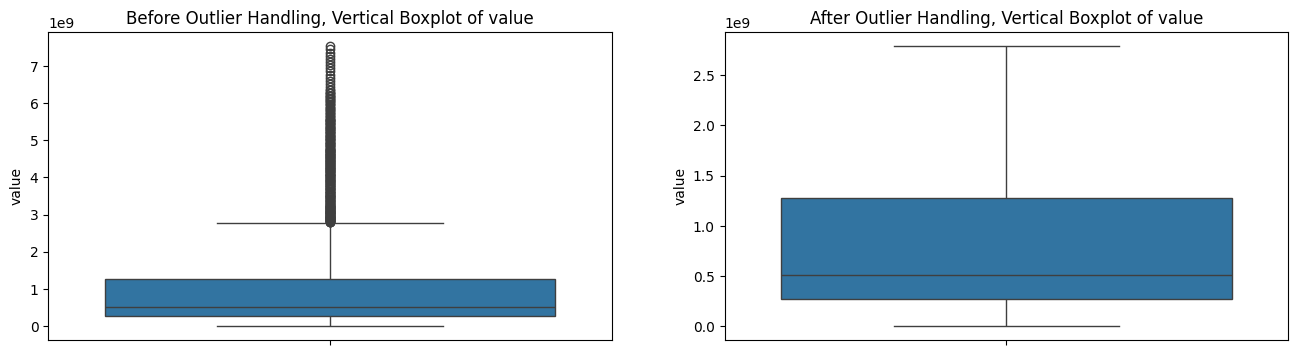

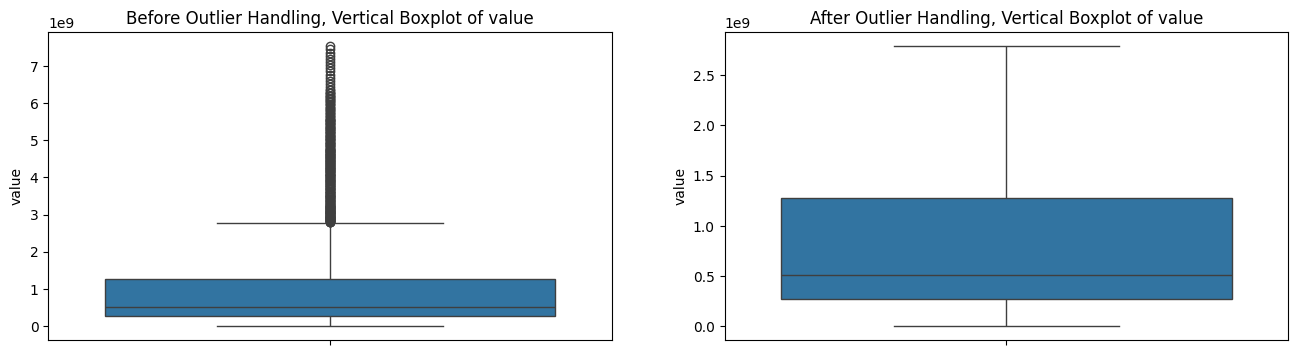

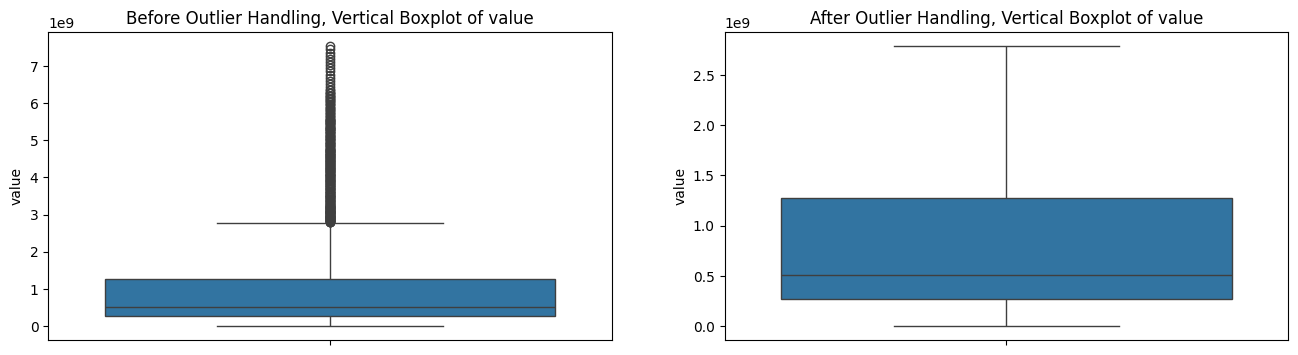

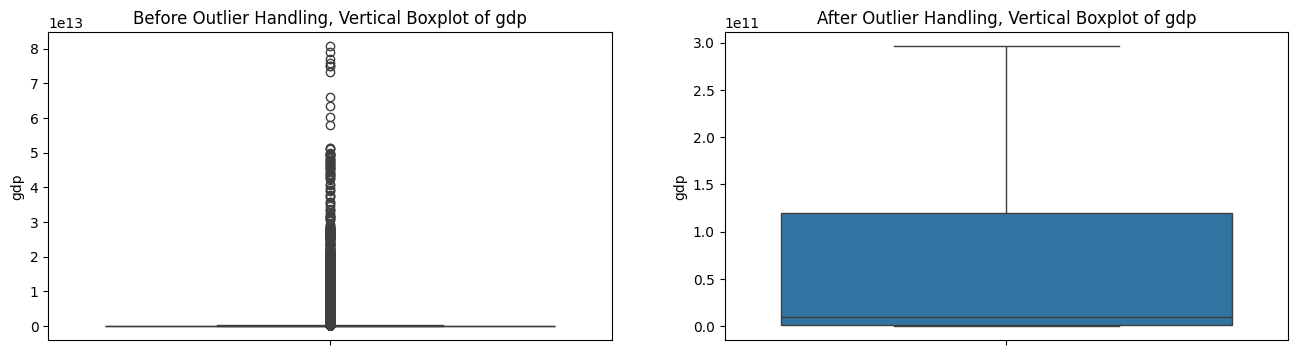

In [38]:
# Assuming you have a list of DataFrames
dfs = [projects_df_capped, population_df_capped, population_json_df_capped, population_sql_df_capped, population_xml_df_capped, gdp_df_capped]

# Iterate over each pair of DataFrames and apply plot_boxplot() function
for df, df_capped in zip([projects_df, population_df, population_json_df, population_sql_df, population_xml_df, gdp_df], dfs):
    plot_boxplot(df, df_capped)

Encoding

In [39]:

# Extract features from datetime column 
date_columns = ['boardapprovaldate', 'closingdate']
for col in date_columns:
    projects_df_capped[col] = pd.to_datetime(projects_df_capped[col])
    projects_df_capped[col + '_year'] = projects_df_capped[col].dt.year
    projects_df_capped[col + '_month'] = projects_df_capped[col].dt.month
    projects_df_capped[col + '_day'] = projects_df_capped[col].dt.day
    projects_df_capped.drop([col],axis=1,inplace=True)
    # Optionally, you can add more features like quarter, day of week, etc.



# Map 'Y' to 1 and 'N' to 0
projects_df_capped['supplementprojectflg'] = projects_df_capped['supplementprojectflg'].map({'Y': 1, 'N': 0})


In [40]:
from sklearn.preprocessing import OrdinalEncoder

def encode_categorical_columns(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            if (11 <= df[column].nunique() < 50) or (column in ['countryname', 'country_name', 'country_code', 'country_or_area', 'prodline', 'lendinginstr', 'productlinetype', 'projectstatusdisplay', 'status']):
                df = pd.get_dummies(df, columns=[column], prefix=column)
            else:
                df.drop([column], axis=1, inplace=True)
    return df.astype(int)


# Encode categorical columns
projects_df_capped = encode_categorical_columns(projects_df_capped)
population_df_capped = encode_categorical_columns(population_df_capped)
population_sql_df_capped = encode_categorical_columns(population_sql_df_capped)
population_xml_df_capped = encode_categorical_columns(population_xml_df_capped)
population_json_df_capped = encode_categorical_columns(population_json_df_capped)
gdp_df_capped = encode_categorical_columns(gdp_df_capped)

In [41]:
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14848 entries, 0 to 14847
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  14848 non-null  object 
 1   country_code  14848 non-null  object 
 2   year          14848 non-null  int32  
 3   gdp           14848 non-null  float64
dtypes: float64(1), int32(1), object(2)
memory usage: 406.1+ KB


In [42]:
num_columns = ['supplementprojectflg',
 'lendprojectcost',
 'ibrdcommamt',
 'idacommamt',
 'totalamt',
 'grantamt',
  'boardapprovaldate_year', 'boardapprovaldate_month', 'boardapprovaldate_day', 'closingdate_year', 'closingdate_month', 'closingdate_day']

population_num_columns = ['year', 'value']

In [43]:
from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler()
projects_df_capped[num_columns] = scaler.fit_transform(projects_df_capped[num_columns]) 

In [44]:
from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler()
projects_df_capped[num_columns] = scaler.fit_transform(projects_df_capped[num_columns]) 
population_df_capped[population_num_columns] = scaler.fit_transform(population_df_capped[population_num_columns]) 
population_sql_df[population_num_columns] = scaler.fit_transform(population_sql_df[population_num_columns]) 
population_json_df_capped[population_num_columns] = scaler.fit_transform(population_json_df_capped[population_num_columns]) 
population_xml_df_capped[population_num_columns] = scaler.fit_transform(population_xml_df_capped[population_num_columns]) 

Feature Engineering

In [45]:

from pycountry import countries

# Add Country Code
# set up the libraries and variables
from collections import defaultdict
country_not_found = [] # stores countries not found in the pycountry library
project_country_abbrev_dict = defaultdict(str) # set up an empty dictionary of string values

# iterate through the country names in df_projects. 
# Create a dictionary mapping the country name to the alpha_3 ISO code
for country in projects_df['countryname'].drop_duplicates().sort_values():
    try: 
        # look up the country name in the pycountry library
        # store the country name as the dictionary key and the ISO-3 code as the value
        project_country_abbrev_dict[country] = countries.lookup(country).alpha_3
    except:
        # If the country name is not in the pycountry library, then print out the country name
        # And store the results in the country_not_found list
        print(country, ' not found')
        country_not_found.append(country)

Africa  not found
Andean Countries  not found
Aral Sea  not found
Asia  not found
Caribbean  not found
Caucasus  not found
Central Africa  not found
Central America  not found
Central Asia  not found
Co-operative Republic of Guyana  not found
Commonwealth of Australia  not found
Democratic Republic of Sao Tome and Prin  not found
Democratic Republic of the Congo  not found
Democratic Socialist Republic of Sri Lan  not found
EU Accession Countries  not found
East Asia and Pacific  not found
Eastern Africa  not found
Europe and Central Asia  not found
Islamic  Republic of Afghanistan  not found
Kingdom of Swaziland  not found
Latin America  not found
Macedonia; former Yugoslav Republic of;Macedonia; former Yugoslav Republic of  not found
Mekong  not found
Mercosur  not found
Middle East and North Africa  not found
Multi-Regional  not found
Organization of Eastern Caribbean States  not found
Oriental Republic of Uruguay  not found
Pacific Islands  not found
Red Sea and Gulf of Aden  not f

In [46]:

# Manually adjust country codes
country_codes = {
    'Africa': 'AFR',
    'Andean Countries': 'AND',
    'Aral Sea': 'ARL',
    'Asia': 'ASI',
    'Caribbean': 'CAR',
    'Caucasus': 'CAU',
    'Central Africa': 'CAF',
    'Central America': 'CAM',
    'Central Asia': 'CAS',
    'Co-operative Republic of Guyana': 'GUY',
    'Commonwealth of Australia': 'AUS',
    'Democratic Republic of Sao Tome and Prin': 'STP',
    'Democratic Republic of the Congo': 'COD',
    'Democratic Socialist Republic of Sri Lan': 'LKA',
    'EU Accession Countries': 'EUA',
    'East Asia and Pacific': 'EAP',
    'Eastern Africa': 'EAF',
    'Europe and Central Asia': 'ECA',
    'Islamic  Republic of Afghanistan': 'AFG',
    'Kingdom of Swaziland': 'SWZ',
    'Latin America': 'LAT',
    'Macedonia; former Yugoslav Republic of;Macedonia; former Yugoslav Republic of': 'MKD',
    'Mekong': 'MEK',
    'Mercosur': 'MCS',
    'Middle East and North Africa': 'MEA',
    'Multi-Regional': 'MRG',
    'Organization of Eastern Caribbean States': 'ECS',
    'Oriental Republic of Uruguay': 'URY',
    'Pacific Islands': 'PCI',
    'Red Sea and Gulf of Aden': 'RED',
    'Republic of Congo': 'COG',
    "Republic of Cote d'Ivoire": 'CIV',
    'Republic of Korea': 'KOR',
    'Republic of Kosovo': 'KOS',
    'Republic of Niger': 'NER',
    'Republic of Rwanda': 'RWA',
    'Republic of Togo': 'TGO',
    'Republic of Turkey': 'TUR',
    'Republic of the Union of Myanmar': 'MMR',
    'Republica Bolivariana de Venezuela': 'VEN',
    'Sint Maarten': 'SXM',
    'Socialist Federal Republic of Yugoslavia': 'YUG',
    "Socialist People's Libyan Arab Jamahiriy": 'LBY',
    'Socialist Republic of Vietnam': 'VNM',
    'Somali Democratic Republic': 'SOM',
    'South Asia': 'SAS',
    'Southern Africa': 'SAF',
    'St. Kitts and Nevis': 'KNA',
    'St. Lucia': 'LCA',
    'St. Vincent and the Grenadines': 'VCT',
    'State of Eritrea': 'ERI',
    'Taiwan; China;Taiwan; China': 'TWN',
    'The Independent State of Papua New Guine': 'PNG',
    'West Bank and Gaza': 'WBG',
    'Western Africa': 'WAF',
    'Western Balkans': 'WBL',
    'World': 'WLD'
}

# Map country codes to country names in merged_df
project_country_abbrev_dict.update(country_codes)

In [47]:

projects_df['country_code'] = projects_df['countryname'].apply(lambda x: project_country_abbrev_dict[x])

In [48]:

# Calculate project cost
projects_df['project_cost'] = projects_df['lendprojectcost'] + projects_df['ibrdcommamt'] + projects_df['idacommamt'] + projects_df['totalamt'] + projects_df['grantamt']

# Group by 'countryname' and sum the project costs
country_project_cost = projects_df.groupby('country_code')['project_cost'].sum().reset_index()


In [49]:
# Merge population_df and gdp_df based on 'country_name', 'country_code', and 'year'
merged_df = pd.merge(population_df, gdp_df, on=['country_name', 'country_code', 'year'], how='left', suffixes=('_pop', '_gdp'))

merged_df = merged_df.dropna()

In [50]:
# Calculate GDP per capita and round it to 2 decimal places
merged_df['gdp_per_capita'] = (merged_df['gdp'] / merged_df['value']).round(2)

In [51]:
# Merge merged_df with country_project_cost using 'countryname' and 'country_name' as the keys
merged_df = pd.merge(merged_df, country_project_cost, on='country_code', how='left')
# Join merged_df with rural_df based on 'country_code' and 'year'
merged_df = pd.merge(merged_df, rural_df[['country_code', 'year', 'ruralpopulationpercent']], on=['country_code', 'year'], how='left')
# Join the resulting DataFrame with electricity_df based on 'country_code' and 'year'
merged_df = pd.merge(merged_df, electricity_df[['country_code', 'year', 'electricityaccesspercent']], on=['country_code', 'year'], how='left')



In [52]:
merged_df.head()

,country_name,country_code,year,value,gdp,gdp_per_capita,project_cost,ruralpopulationpercent,electricityaccesspercent
0,Arab World,ARB,1960,92490932.0,2.576068e+10,278.52,NaN,68.708026,74.384239
1,Central Europe and the Baltics,CEB,1960,91401583.0,2.563911e+11,2805.11,NaN,55.492079,100.000000
2,Caribbean small states,CSS,1960,4198307.0,1.904499e+09,453.63,NaN,68.406337,76.934516
3,East Asia & Pacific (excluding high income),EAP,1960,893956327.0,8.025455e+10,89.77,109840000.0,83.079190,82.599168
4,Early-demographic dividend,EAR,1960,979287407.0,1.385642e+11,141.49,NaN,77.049154,53.079299


In [53]:
# Fill NaN values in 'project_cost' column with 0
merged_df['project_cost'].fillna(0, inplace=True)

# Fill NaN values in 'ruralpopulationpercent' column with 0
merged_df['ruralpopulationpercent'].fillna(0, inplace=True)

# Fill NaN values in 'electricityaccesspercent' column with 0
merged_df['electricityaccesspercent'].fillna(0, inplace=True)


C:\Users\Dans\AppData\Local\Temp\ipykernel_9700\1843537688.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['project_cost'].fillna(0, inplace=True)
C:\Users\Dans\AppData\Local\Temp\ipykernel_9700\1843537688.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [54]:
# Fill NaN values in 'project_cost' column with 0
merged_df['project_cost'].fillna(0, inplace=True)

# Fill NaN values in 'ruralpopulationpercent' column with 0
merged_df['ruralpopulationpercent'].fillna(0, inplace=True)

# Fill NaN values in 'electricityaccesspercent' column with 0
merged_df['electricityaccesspercent'].fillna(0, inplace=True)

# Rename columns and add underscores
merged_df.rename(columns={
    'value': 'population',
    'ruralpopulationpercent': 'rural_population_percent',
    'electricityaccesspercent': 'electricity_access_percent'
}, inplace=True)


Data Loading

In [55]:
# Save to CSV file
merged_df.to_csv('world_bank_final_data.csv', index=False)


In [56]:
# Save to PostgreSQL database with default configuration
from sqlalchemy import create_engine

# Define the default PostgreSQL connection parameters
db_config = {
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5432',
    'database': 'postgres'
}

# Create a SQLAlchemy engine
engine = create_engine(f'postgresql://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["database"]}')

# Save to PostgreSQL database
merged_df.to_sql('world_bank', engine, index=False, if_exists='replace')

ModuleNotFoundError: No module named 'psycopg2'

Data Vizualitation

**projects_data.csv**

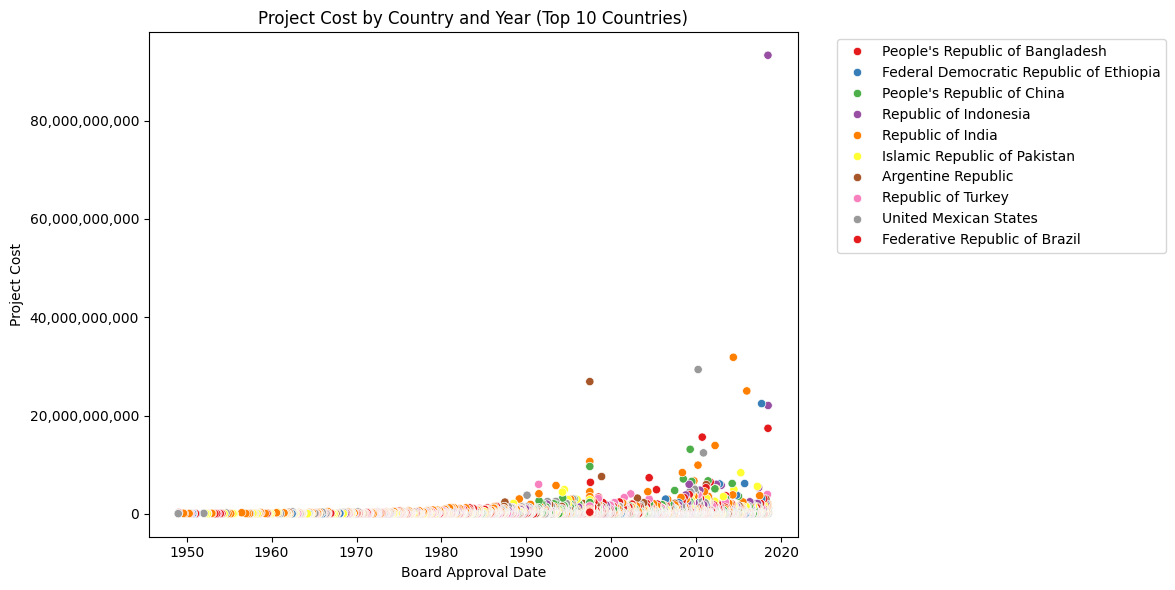

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Get top 10 countries by total project cost
top_10_countries = projects_df.groupby('countryname')['project_cost'].sum().nlargest(10).index

# Filter the projects_df for only the top 10 countries
filtered_df = projects_df[projects_df['countryname'].isin(top_10_countries)]

# Scatter plot: Project cost by country and year (top 10 countries)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=filtered_df, x='boardapprovaldate', y='project_cost', hue='countryname', palette='Set1')
plt.title('Project Cost by Country and Year (Top 10 Countries)')
plt.xlabel('Board Approval Date')
plt.ylabel('Project Cost')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Format y-axis as float
plt.tight_layout()
plt.show()


C:\Users\ACER\AppData\Local\Temp\ipykernel_26952\3568669123.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_countries, x='countryname', y='project_cost', palette='viridis')


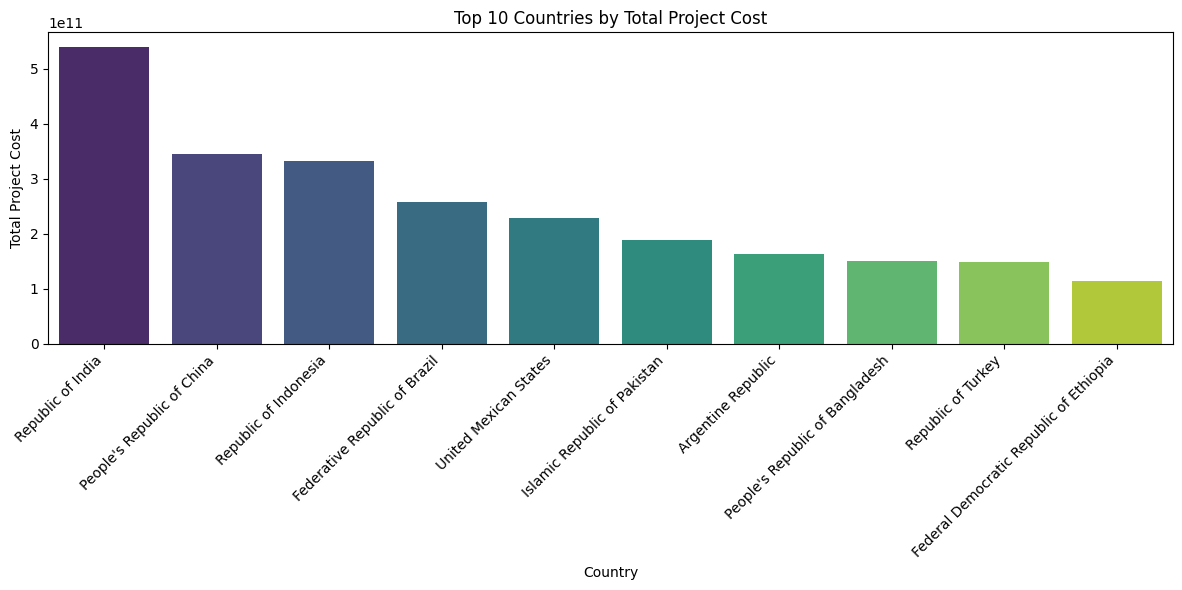

In [ ]:
 
# Calculate total project cost for each country
total_cost_by_country = projects_df.groupby('countryname')['project_cost'].sum().reset_index()

# Select the top 10 countries with the highest total project cost
top_10_countries = total_cost_by_country.nlargest(10, 'project_cost')

# Bar plot: Total project cost by country (top 10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_countries, x='countryname', y='project_cost', palette='viridis')
plt.title('Top 10 Countries by Total Project Cost')
plt.xlabel('Country')
plt.ylabel('Total Project Cost')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15254 entries, 0 to 15253
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  15254 non-null  object 
 1   country_code  15254 non-null  object 
 2   year          15254 non-null  int32  
 3   value         15254 non-null  float64
dtypes: float64(1), int32(1), object(2)
memory usage: 536.3+ KB


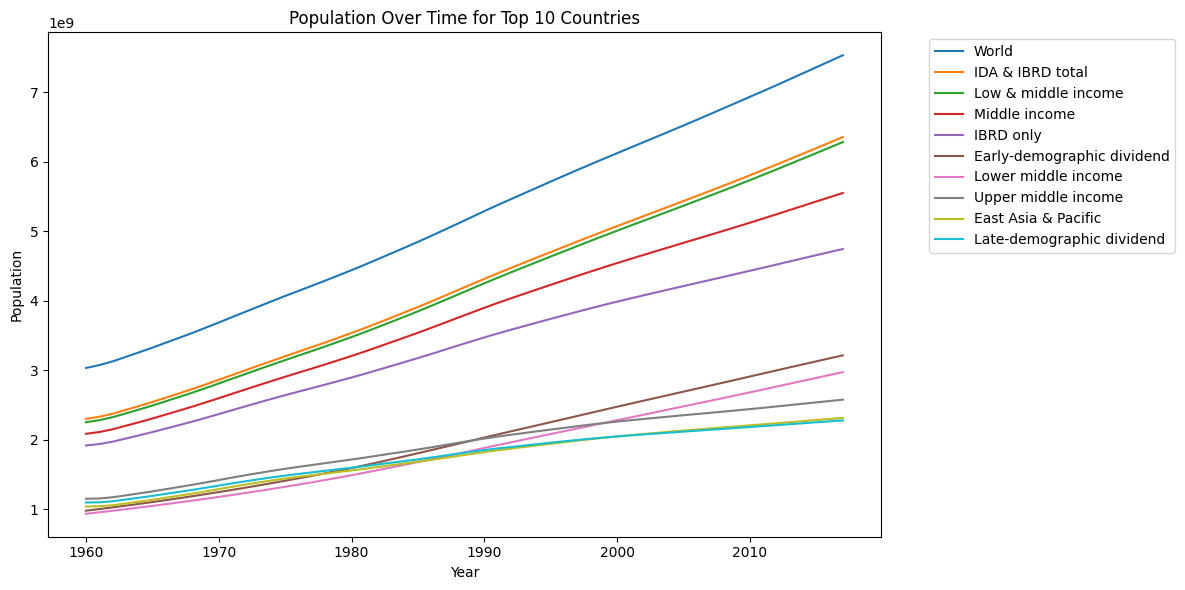

C:\Users\ACER\AppData\Local\Temp\ipykernel_26952\2470636281.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_countries_latest_year, x='value', y='country_name', palette='Set1')


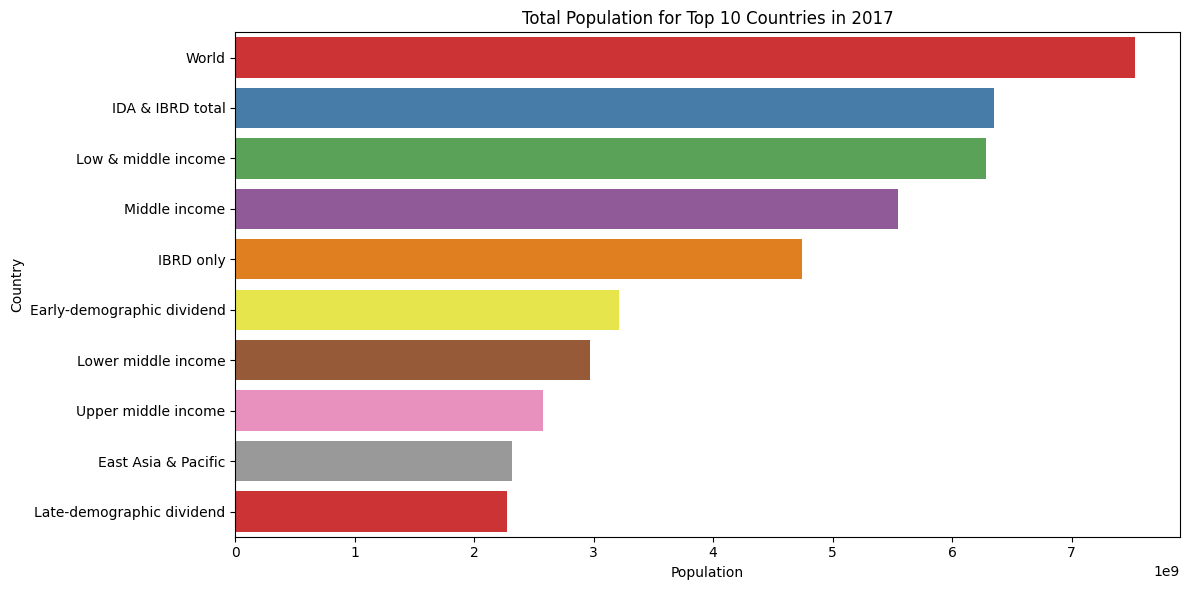

In [ ]:
 # Group the population DataFrame by country and year and calculate the total population
population_by_country_year = population_df.groupby(['country_name', 'year'])['value'].sum().reset_index()

# Get the latest year
latest_year = population_by_country_year['year'].max()

# Select the top 10 countries with the highest population in the latest year
top_10_countries_latest_year = population_by_country_year[population_by_country_year['year'] == latest_year]\
                                    .nlargest(10, 'value')

# Plot 1: Line plot showing population over time for top 10 countries
plt.figure(figsize=(12, 6))
for country in top_10_countries_latest_year['country_name'].unique():
    country_data = population_by_country_year[population_by_country_year['country_name'] == country]
    plt.plot(country_data['year'], country_data['value'], label=country)

plt.title('Population Over Time for Top 10 Countries')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot 2: Bar plot showing total population for top 10 countries in the latest year
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_countries_latest_year, x='value', y='country_name', palette='Set1')
plt.title(f'Total Population for Top 10 Countries in {latest_year}')
plt.xlabel('Population')
plt.ylabel('Country')
plt.tight_layout()
plt.show()
